# Week 10 Lesson: GPT, T5, and the Modern Large Language Model


## Introduction
Last week we explored the Transformer architecture and how **BERT** learns bidirectional representations for language understanding tasks.  
This week we’ll continue the story with two major descendants — **GPT** and **T5** — and then examine **how modern LLMs are trained, aligned, and deployed** for human interaction.

## Learning Objectives

* **Differentiate** GPT (decoder-only, autoregressive) and T5 (encoder–decoder, text-to-text) in terms of architecture and training objective.
* **Explain** the three training stages—**pretraining**, **fine-tuning**, and **alignment**—and when each is used.
* **Diagram/describe** the RLHF pipeline (base model → human rankings → reward model → policy update) and **identify** potential sources of bias.
* **Implement** a minimal Chat Completions API call and **configure** core parameters (`temperature`, `max_tokens`, system/user roles).
* **Experiment** with temperature and few-shot prompts to **analyze** effects on fluency, faithfulness, and task performance.



### Some (Recent) History

Since their introduction in 2017, Transformers have reshaped nearly every area of artificial intelligence. Originally developed for language translation, the architecture soon proved remarkably general, capturing deep patterns in language when pretrained on massive amounts of unlabeled text and later fine-tuned for specific tasks. This paradigm—large-scale pretraining followed by transfer learning—became the foundation of today’s generative AI revolution. The same architecture now drives systems that generate not only text but also images, music, audio, and even actions for AI agents such as robots and drones. 

Transformer adoption was accelerated by open-source frameworks such as **PyTorch**, **Keras/TensorFlow**, and especially **Hugging Face’s Transformers library,** which made these models accessible to anyone able to write a few lines of code. Advances in specialized hardware, like NVIDIA’s Tensor Cores, further boosted their speed and scalability. Most visibly, the 2022 launch of **ChatGPT** brought Transformers and Large Language Models into mainstream awareness, demonstrating near-human performance on complex reasoning and professional tasks and marking a turning point in how people use AI. 

To see how explosive has been the growth of transformer models, compare the "Transformer Family Tree" from last week (which covered only the developments up through 2021) with a much more complex tree from only two years later!

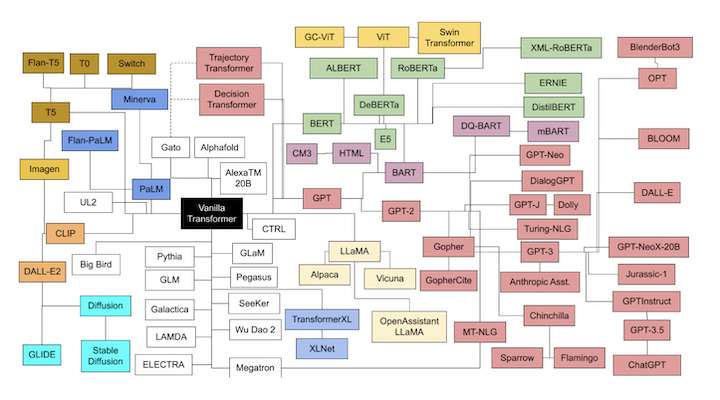

(Color code: black for foundation models, green for encoder-only, red for decoder-only, blue for diffusion models.) 

Another presentation of this collection, aligned by year and the number of trainable parameters, shows the 
massive effort being made to scale these models to achieve better and better performance:

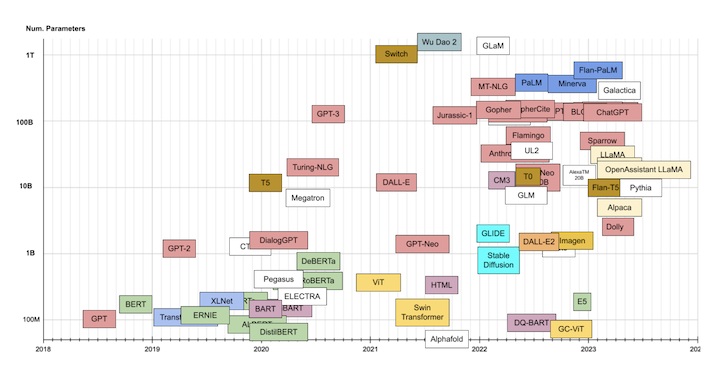

A significant trend in recent years has been the focus on retraining or fine-tuning models to achieve
best performance. **Foundation models** are large models trained on vast, general-purpose data—usually through self-supervised learning—that can later be **fine-tuned** for specific tasks. This approach, popularized by **BERT** in 2018, transformed natural language processing by allowing pretrained models to be adapted with small labeled datasets, leading to Transformer dominance across benchmarks like GLUE and SQuAD. 

In previous weeks, we have learned how traditional fine-tuning added new layers for task-specific outputs, but with **generative models** such as GPT, the pretrained model itself can perform diverse text generation tasks through next-token prediction. However, early GPTs were often unhelpful or inaccurate, leading to **InstructGPT**—fine-tuned with human-labeled data to better follow instructions. 

This principle now underlies systems like **ChatGPT**, where models are refined using **Reinforcement Learning from Human Feedback (RLHF)**. Beyond text generation, similar fine-tuning produces models optimized for semantic embeddings, classification, and retrieval, showing how foundation models evolve through successive stages of specialization and alignment.

Although this area continues to advance and change almost daily, we'll conclude this brief introduction with
"where are we now?"

### State of the Art — October 2025

* **GPT-5 (OpenAI, 2025)** – A fully **multimodal** model (text, vision, audio, and tools) powering ChatGPT and Microsoft Copilot. It demonstrates more consistent reasoning, longer memory, and better integration with APIs and documents.
  *Key shift:* from language modeling → general reasoning and task orchestration.

* **Mixture-of-Experts (MoE) Models** – Systems such as **Gemini 2**, **Claude 3.5**, and **Mixtral 8×22B** dynamically route prompts to specialized “expert” sub-networks, achieving higher performance with lower compute cost.

* **Open-Source Renaissance** – Projects like **Llama 3**, **Mistral 7B**, and **nanochat** (Karpathy, 2025) make small, trainable LLMs widely accessible for teaching and research—often runnable on a single GPU or even laptop.

* **Hardware Advances** – NVIDIA’s **Blackwell** GPUs and custom **TPU v6** chips provide mixed-precision (FP8/FP16) computation for faster and cheaper large-model training and inference.


In [1]:
# If needed in your environment, uncomment to install packages
# !pip install -U transformers accelerate torch --quiet
# !pip install -U openai --quiet


## GPT-2 and T5

Last week we demonstrated `BERT` as an early and influential example of the encoder-only transformer model. 
Now we'll complete the survey of basic approaches to the transformer architecture by demonstrating
`GPT-2` (Generative Pretrained Transformer), a decoder-only model, and `T5` (Text-To_Text Transfer Transformer), which includes both encoder and decoder stages. We may summarize their main characteristics in this table:


| Model | Architecture | Training Objective | Example Tasks |
|--------|---------------|-------------------|----------------|
| **GPT-2 (Generative Pretrained Transformer)** | Decoder-only | Next-token prediction (autoregressive) | Text generation, dialogue, reasoning |
| **T5 (Text-to-Text Transfer Transformer)** | Encoder–decoder | Denoising autoencoder (fill in masked spans) | Summarization, translation, QA, paraphrasing |


### 🔍 GPT-2 Demo 1 — Autoregressive text generation

Given a prompt, GPT will produce one-word-at-a-time autoregressive continuations as long as you like!
Note that you can set the
- Prompt
- Temperature
- Top-P percentage

(And many other parameters such as `top_k` and  `repetition_penalty` to prevent repeating words and phrases.) 


What happens in each step (Hugging Face `generate/pipeline`):

1. **Model computes logits** for next token. (In binary cases, “logit” often means $\log\!\left(\tfrac{p}{1-p}\right)$; in LLMs, “logits” are multi-class generalization, one score per token.)

2. Apply **Temperature Scaling** to adjust sharpness. Scale logits by `1/T` (e.g., `logits /= 0.8`).

   * `T<1` → sharper (more confident), `T>1` → flatter (more random).
3. Apply **Top-P (Nucleus) Filtering:** To keep only the most probable subset.: Sort tokens by probability, keep the smallest set whose **cumulative prob ≥ p** (e.g., 0.95), set the rest to `-inf` (they can’t be chosen).

4.  **Softmax & sample** the next token from the remaining tokens (multinomial draw).


**Practical tips:**

* If outputs feel too deterministic, raise `temperature` or `top_p` (e.g., `T=1.0, top_p=0.95`).
* If outputs wander or ramble, lower `top_p` (e.g., `0.8–0.9`) or lower `temperature` (e.g., `0.6–0.8`).
* Avoid setting both very restrictive (e.g., `T=0.3` *and* `top_p=0.7`)—the sampling distribution will become almost deterministic, with little variation in sentences produced. 


In [24]:
import torch
from transformers import pipeline

# Pick CUDA → MPS → CPU
device = 0 if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else -1)

gen = pipeline(
    "text-generation",
    model="gpt2",                     # or "gpt2-medium"
    device=device,                    # use GPU/MPS if available
    torch_dtype=torch.float32,        # good default, esp. for MPS
    clean_up_tokenization_spaces=False
)

result = gen(
    "Artificial intelligence will",
    max_new_tokens=200,
    do_sample=True, temperature=0.8, top_p=0.95,
    pad_token_id=gen.tokenizer.eos_token_id  # GPT-2 has no pad token
)

print(result[0]["generated_text"])


Artificial intelligence will make it possible to build robots that are both easy to understand and easy to make.

According to the study by the MIT researchers, artificial intelligence will create an "intelligent person," but not a robot.

It's a big leap from "the big-picture perspective" to "the real-world perspective," said the authors, who say this would mean that a robot could be built in many different ways.

The human-made robot could be used to walk, read, play and interact with objects, said the paper, published online in the journal Science.

"It's really the AI that has to do everything," said Dr. David Nel, an assistant professor of human-computer interaction at MIT, who co-authored the research.

"We can do lots of things. We can do all kinds of things. We can do things that we've never done before, and it will be just amazing."

Nel said the research


**temperature=1.0, top_p=0.95**
    
    Artificial intelligence will become the dominant paradigm for the next twenty or thirty years, but there are other advances that will benefit the world at large. These include artificial intelligence, intelligent robots, and the human-computer interaction.
    
    
    In addition to artificial intelligence, artificial intelligence will replace human labor as the dominant form of employment. Robots will replace the more important industrial jobs that we already face in our lives, including the production, transportation, and marketing of goods and services.
    
    
    Robots will be able to work and support people who will no longer want to be on the job. Many industries are looking to robots in new areas of production and management to manage their workforce.
    
    
    As we see it, the world will rapidly replace human labor. As robots replace humans, the human workers will become more useful than they have ever been, which will help to alleviate the shortage of human human labor that is the main cause of the current crisis of the economy.
    
    
    As we enter the next phase, and as technology

**temperature=0.75, top_p=0.9**
    
    Artificial intelligence will eventually be able to replace humans in everything we do.
    
    This may seem like a big deal, but it is far from clear what this technology will look like. Even if the AI is able to help us, we will never have a good idea of what it will do to us.
    
    A new generation of artificial intelligence will emerge that will not only be able to help us in every sense of the word, but also help us to understand ourselves, our world, and our lives.
    
    And it will be able to do it in a way that will be very meaningful to all of us.
    
    It will be able to think and act in ways that are both self-evident and self-evident to everyone who has ever had a chance to learn about them.
    
    It will be able to do things that are both self-evident and self-evident to others.
    
    It will be able to do things that are both self-evident

**temperature=0.2, top_p=0.5**
    
    Artificial intelligence will be able to do things like search for and find people, and to find people who are not in the same situation as you.
    
    "We're going to be able to do things like search for and find people, and to find people who are not in the same situation as you."
    
    The AI will also be able to do things like search for and find people, and to find people who are not in the same situation as you.
    
    "We're going to be able to do things like search for and find people, and to find people who are not in the same situation as you."
    
    The AI will also be able to do things like search for and find people, and to find people who are not in the same situation as you.
    
    "We're going to be able to do things like search for and find people, and to find people who are not in the same situation as you.
    
    "We're going to be able to do

**temperature=2.0, top_p=0.9**
    
    Artificial intelligence will transform many aspects of health into science fiction, for science, of a world not completely artificial." There is no better metaphor than this — in order, like it and so often like it, to justify that change I quote Richard Posner, "'They believe in being in touch'; and a person who feels pain and feels as if through a telepathic, spiritual body, a consciousness that will allow itself completely unrestricted passage by means other than physical contact and the transmission-control of matter." In that vision we might as already speak.
    
    
    Science should know more about what science may provide for us. The most urgent issues concerning human consciousness in this coming decades are questions and anxieties still being raised — from concerns raised over mass migration — about the effects of mass vaccination in parts of Africa. Concern also is over the implications. Will there be mass vaccinations, a state of near indifference or even a partial halt in most areas from an outbreak and possible death toll of more than one million who might not otherwise

**temperature=5.0, top_p=0.9**
    
    Artificial intelligence will only reach those skills before real-mannered dogs—in large, human cases for decades without artificial language; as it gets nearer us it cannot come. By 2050 we still face our largest challenge ahead (a huge need!), such in fact there will likely have nothing worse to want now so it feels good! Here too our quest for technology in our lives won´ve just added complexity into your world...The time's just too cool... And this isn. What shall Humanity say next that has to change how one operates, if its life cycle ends? "No humans need live space aliens just to fill those "empty world", but "not much needed", or simply if it were only 10m (yes they do exist... ) and it came all too low on gas there has ever seen..."It may go to waste but our best use (and that is in building everything we have as real worlds)" But where. Where are that empty air? The "future-beats": in

### GPT-2 Demo 2: Style Mimicry

This demo shows how a small, few-shot “primer” can nudge GPT-2 to imitate surface style—tone, cadence, and structure—without any fine-tuning. We provide a handful of examples (e.g., Shakespearean couplets vs. tech press release), then ask for new text on a fresh topic in the same style, comparing creative vs. conservative sampling to highlight strengths and limits.


In [3]:
# If needed:
# !pip install transformers torch --quiet

# !pip install transformers torch --quiet

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
tok = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.eval()

# Make padding explicit & consistent
tok.pad_token = tok.eos_token
model.config.pad_token_id = tok.eos_token_id

def build_prompt(style_name, examples, new_topic):
    """
    style_name: string describing the style
    examples: list of (topic, text) pairs as short exemplars
    new_topic: topic to write about in the same style
    """
    lines = [f"STYLE: {style_name}", "EXAMPLES:"]
    for k, v in examples:
        lines += [f"Theme: {k}", f"Text: {v}", "---"]
    lines += [f"Now produce text in the SAME style.\nTheme: {new_topic}", "Text:"]
    return "\n".join(lines)

@torch.no_grad()
def generate(prompt, max_new_tokens=80, temperature=0.8, top_p=0.95, seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    enc = tok(prompt, return_tensors="pt", return_attention_mask=True)
    input_ids = enc["input_ids"].to(device)
    attn_mask = enc["attention_mask"].to(device)

    out_ids = model.generate(
        input_ids,
        attention_mask=attn_mask,
        do_sample=True,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        repetition_penalty=1.1,
        pad_token_id=tok.pad_token_id
    )
    full = tok.decode(out_ids[0], skip_special_tokens=True,
                      clean_up_tokenization_spaces=True)
    return full[len(prompt):].strip()

# -------------------------------
# A) Shakespearean couplet style
# -------------------------------
shakespeare_examples = [
    ("jealousy",  "Green-eyed the heart, that shadows love with doubt;\nYet truth, once shown, will chase the phantoms out."),
    ("betrayal",  "A smiling lip may hide a dagger’s art;\nWhat’s sweet in speech may sour a faithful heart."),
    ("ambition",  "Stars bid me climb beyond my humble sphere;\nBut pride that soars may fall for flying near.")
]

prompt_shake = build_prompt(
    style_name="Shakespearean rhymed couplets (two lines, iambic feel, elevated diction)",
    examples=shakespeare_examples,
    new_topic="machine learning"
)

print("=== Shakespearean style (creative) ===")
print(generate(prompt_shake, temperature=0.9, top_p=0.95, seed=123), "\n")

print("=== Shakespearean style (conservative) ===")
print(generate(prompt_shake, temperature=0.3, top_p=0.9, seed=123))


# -------------------------------
# B) Tech press-release style
# -------------------------------
press_examples = [
    ("product launch", "Today we announced Nimbus 2.0, delivering real-time analytics at enterprise scale. "
                       "The update simplifies deployment and cuts total cost of ownership."),
    ("partnership",    "We’re partnering with Acme Labs to accelerate AI adoption. "
                       "Customers can now integrate models securely in under ten minutes."),
    ("milestone",      "With 5 million monthly active users, the platform now supports role-based access, "
                       "auditing, and SOC 2 Type II compliance.")
]

prompt_press = build_prompt(
    style_name="Concise tech press release (2–3 sentences, benefits > features, concrete claims)",
    examples=press_examples,
    new_topic="on-device model for privacy"
)

print("\n=== Press release style (creative) ===")
print(generate(prompt_press, temperature=0.9, top_p=0.95, seed=7), "\n")

print("=== Press release style (conservative) ===")
print(generate(prompt_press, temperature=0.3, top_p=0.9, seed=7))


/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


=== Shakespearean style (creative) ===
An endless series of rules are chosen to form an entire system upon which all life is built on its own foundation; *this includes many systems such as human mind and brain... [insert code here] ---
This should be your first introduction to our next theme design!  Check back often enough - we're going full circle now :) 

=== Shakespearean style (conservative) ===
The mind is not only an instrument of thought but also a tool to manipulate it and control its actions. It can be used as well as any other human being's brain by anyone who has ever been taught how or why they should act on their own thoughts—or even if those ideas are wrong!

=== Press release style (creative) ===
Automation enables you enable instant updates while maintaining all your data collection capabilities like voice volume controls or GPS location records. As a reminder, this is not an API version... it's open source software development tool! 💩️ A single button will bring up s

In [26]:
# If needed (first run):
# !pip install transformers torch ipywidgets --quiet
# In JupyterLab: ensure ipywidgets is enabled; usually no extra step required.

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import ipywidgets as W
from IPython.display import display, Markdown

# ---- Load model/tokenizer ----
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.eval()

# Make padding explicit & consistent; silence future warning later
tok.pad_token = tok.eos_token
model.config.pad_token_id = tok.eos_token_id

# ---- Styles (add your own!) ----
STYLES = {
    "Shakespearean couplets": {
        "style_name": "Shakespearean rhymed couplets (two lines, iambic feel, elevated diction)",
        "examples": [
            ("jealousy",  "Green-eyed the heart, that shadows love with doubt;\nYet truth, once shown, will chase the phantoms out."),
            ("betrayal",  "A smiling lip may hide a dagger’s art;\nWhat’s sweet in speech may sour a faithful heart."),
            ("ambition",  "Stars bid me climb beyond my humble sphere;\nBut pride that soars may fall for flying near.")
        ],
        "default_topic": "machine learning"
    },
    "Tech press release": {
        "style_name": "Concise tech press release (2–3 sentences, benefits > features, concrete claims)",
        "examples": [
            ("product launch", "Today we announced Nimbus 2.0, delivering real-time analytics at enterprise scale. "
                               "The update simplifies deployment and cuts total cost of ownership."),
            ("partnership", "We’re partnering with Acme Labs to accelerate AI adoption. "
                            "Customers can now integrate models securely in under ten minutes."),
            ("milestone", "With 5 million monthly active users, the platform now supports role-based access, "
                          "auditing, and SOC 2 Type II compliance.")
        ],
        "default_topic": "on-device model for privacy"
    },
    "Hard-boiled noir": {
        "style_name": "Hard-boiled noir narrator (short, gritty sentences; first person; moody metaphors)",
        "examples": [
            ("a rainy night", "Rain drilled the city like a bad alibi. I kept walking."),
            ("a missing file", "The folder was gone. So was my patience."),
            ("a suspect", "He smiled with his mouth, not his eyes. I took notes.")
        ],
        "default_topic": "a mysterious dataset"
    },
    "Machine-Learning Textbook": {
    "style_name": "Machine learning textbook (formal, precise, explanatory; defines terms and relates them logically)",
    "examples": [
        ("linear regression",
         "Linear regression models the relationship between a scalar response and one or more explanatory variables by fitting a linear equation to observed data."),
        ("decision trees",
         "Decision trees partition the feature space into regions using axis-aligned splits, producing an interpretable model that can capture nonlinear relationships."),
        ("cross-validation",
         "Cross-validation is a resampling procedure used to estimate model performance by partitioning the data into complementary subsets for training and validation."),
        ("ROC curve", "The ROC curve is a popular graphic for simultaneously displaying the two types of errors for all possible thresholds"),
        ("validation set", "It was mentioned in Section 5.1.1 that the validation set approach can lead to overestimates of the test error rate."),
        ("tree-based methods","Tree-based methods are simple and useful for interpretation, however, they typically are not competitive with the best supervised learning approaches.")
    ],
    "default_topic": "bias-variance tradeoff"
}

}

def build_prompt(style_name, examples, new_topic):
    lines = [f"STYLE: {style_name}", "EXAMPLES:"]
    for k, v in examples:
        lines += [f"Theme: {k}", f"Text: {v}", "---"]
    lines += [f"Now produce text in the SAME style.\nTheme: {new_topic}", "Text:"]
    return "\n".join(lines)

@torch.no_grad()
def generate(prompt, max_new_tokens=80, temperature=0.8, top_p=0.95, seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    enc = tok(prompt, return_tensors="pt", return_attention_mask=True)
    input_ids = enc["input_ids"].to(device)
    attn_mask = enc["attention_mask"].to(device)

    out_ids = model.generate(
        input_ids,
        attention_mask=attn_mask,
        do_sample=True,
        max_new_tokens=max_new_tokens,
        temperature=float(temperature),
        top_p=float(top_p),
        repetition_penalty=1.1,
        pad_token_id=tok.pad_token_id
    )
    txt = tok.decode(out_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return txt[len(prompt):].strip()

# ---- Widgets ----
style_dd = W.Dropdown(options=list(STYLES.keys()), value="Shakespearean couplets", description="Style:")
topic_tb = W.Text(placeholder="Enter topic…", description="Topic:", layout=W.Layout(width="60%"))
temp_sl  = W.FloatSlider(value=0.7, min=0.0, max=1.5, step=0.05, description="Temperature:", readout_format=".2f")
topp_sl  = W.FloatSlider(value=0.95, min=0.1, max=1.0, step=0.01, description="top_p:", readout_format=".2f")
len_sl   = W.IntSlider(value=80, min=16, max=200, step=1, description="Max tokens:")
seed_tb  = W.IntText(value=123, description="Seed:")
go_btn   = W.Button(description="Generate", button_style="primary")
out      = W.Output()

def on_style_change(change):
    meta = STYLES[style_dd.value]
    if not topic_tb.value:
        topic_tb.value = meta["default_topic"]

style_dd.observe(on_style_change, names="value")
on_style_change(None)

def run_generation(_):
    out.clear_output()
    meta = STYLES[style_dd.value]
    topic = topic_tb.value or meta["default_topic"]
    prompt = build_prompt(meta["style_name"], meta["examples"], topic)

    text_creative = generate(prompt, max_new_tokens=len_sl.value,
                             temperature=temp_sl.value, top_p=topp_sl.value, seed=seed_tb.value)
    text_conserv  = generate(prompt, max_new_tokens=len_sl.value,
                             temperature=0.3, top_p=0.9, seed=seed_tb.value)

    with out:
        display(Markdown(f"### Style: **{style_dd.value}**"))
        display(Markdown(f"**Topic:** {topic}"))
        display(Markdown("**Creative (higher temperature: set in slider):**"))
        print(text_creative, "\n")
        display(Markdown("**Conservative (lower temperature, fixed at 0.3):**"))
        print(text_conserv)

go_btn.on_click(run_generation)

# ---- Layout ----
controls = W.VBox([
    style_dd,
    topic_tb,
    W.HBox([temp_sl, topp_sl]),
    W.HBox([len_sl, seed_tb]),
    go_btn
])

display(controls, out)


Output()

### T5: Text-to-text Transfer Transformer

T5 (Text-to-Text Transfer Transformer) reframes every NLP task—translation, summarization, question answering, and classification—as a **text-to-text** problem: the model always takes in text and outputs text.

Unlike GPT-2, which simply predicts the next token in a sequence, T5 was explicitly **trained on labeled tasks** (the *Colossal Clean Crawled Corpus* plus supervised datasets) with task prefixes such as `"summarize:"`, `"translate English to French:"`, or `"classify sentiment:"`.
This makes it a perfect bridge between the *unsupervised GPT-2* era and *instruction-following* models like GPT-3.5 and GPT-5.

>Colossal Clean Crawled Corpus (C4) is a large, English-focused webtext dataset built by taking a Common Crawl snapshot (Apr 2019) and applying heuristic filters—language detection, removal of boilerplate/short or non-linguistic pages, deduplication, and a “bad-words” blocklist—to yield cleaner text for pretraining models like T5. Typical stats: on the order of hundreds of GB (TFDS reports ~807 GiB for c4/en) and about 156 B tokens in the cleaned English release documented by Dodge et al

#### T5 Demo 1:  Translation

-  Tasks are phrased in natural language—the prefix tells the model *what to do*, not just *what to predict next*.

In [5]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tok = T5Tokenizer.from_pretrained("t5-small", legacy=True)  # keep old behavior, no warning
model = T5ForConditionalGeneration.from_pretrained("t5-small")


def t5_run(task):
    input_ids = tok(task, return_tensors="pt").input_ids
    output_ids = model.generate(input_ids, max_new_tokens=60)
    return tok.decode(output_ids[0], skip_special_tokens=True)

print(t5_run("translate English to French: Machine learning is powerful and fascinating."))
print(t5_run("translate English to German: Machine learning is powerful and fascinating."))
print(t5_run("translate English to Spanish: Machine learning is powerful and fascinating."))


L'apprentissage en machine est puissant et fascinant.
Das Maschinelle Lernen ist mächtig und faszinierend.
Das Spanische ist mächtig und faszinierend.


#### T5 Demo 2:  Summarization

- GPT-2 cannot summarize coherently without long prompting; T5 was trained directly for summarization.


In [27]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

tok = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
model.config.pad_token_id = tok.pad_token_id
model.config.eos_token_id = tok.eos_token_id

# >>> KEY FIX: put the model on the same device (keep float32 on MPS)
model.to(device, dtype=torch.float32)
model.eval()

@torch.inference_mode()
def t5_generate(prompt, max_new=64, min_new=20):
    enc = tok(prompt, return_tensors="pt", padding=True, truncation=True)
    enc = {k: v.to(device) for k, v in enc.items()}  # inputs on same device
    out_ids = model.generate(
        **enc,
        max_new_tokens=max_new,
        min_new_tokens=min_new,
        num_beams=4,
        no_repeat_ngram_size=3,
    )
    return tok.decode(out_ids[0], skip_special_tokens=True)

# Summarization
text = ("Emma Woodhouse, handsome, clever, and rich, with a comfortable home \
and happy disposition, seemed to unite some of the best blessings of \
existence; and had lived nearly twenty-one years in the world with very \
little to distress or vex her. \
She was the youngest of the two daughters of a most affectionate, \
indulgent father; and had, in consequence of her sister's marriage, been \
mistress of his house from a very early period. Her mother had died \
too long ago for her to have more than an indistinct remembrance of \
her caresses; and her place had been supplied by an excellent woman as governess, who had fallen little short of a mother in affection.")
        
print(t5_generate("summarize: " + text))


her mother had died too long ago for her to have more than an indistinct remembrance of her caresses. her place had been supplied by an excellent woman as governess.


#### T5 Demo 3:  Question Answering

In [7]:
from transformers import pipeline
device = 0 if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else -1)

qa = pipeline("question-answering",
              model="distilbert-base-cased-distilled-squad",
              device=device)

def Q_and_A(Q,context):
    print(qa({"question": Q, "context": context})['answer'])

context = ("Gradient descent is an optimization algorithm that updates model parameters by "
           "moving in the direction opposite the gradient of the loss function.")

Q_and_A("What does gradient descent do?",context)

updates model parameters


In [8]:
Q_and_A("How old was Emma Woodhouse?",text)

twenty-one years


In [9]:
Q_and_A("Was Emma's mother alive or dead?",text)

died


In [10]:
Q_and_A("Did Emma Woodhouse have a sister?",text)

She was the youngest of the two daughters


In [11]:
Q_and_A("How many sisters did Emma Woodhouse have?",text)

two


### The Modern Era of LLMs with GPT-5: From “text-to-text” to general AI assistant

GPT-5 is a large, instruction-following model that unifies what you’ve seen so far—GPT-2’s generative fluency and T5’s task-prompting—while adding robust **reasoning**, **long-context memory**, and **tool use**. It follows natural prompts, carries multi-turn conversations with continuity, and can call external tools (search, code, data) when asked. Modern training (supervised fine-tuning + human/preference feedback) makes outputs more helpful, concise, and safer than earlier models. GPT-5 also supports **multimodal** inputs/outputs and can return **structured** results (JSON) for automation. In short: it’s not just a text generator—it’s a configurable assistant that can reason, cite, structure, and integrate with your workflow.



#### How Large Language Models Are Trained


Training an LLM typically proceeds in **three major stages**:

**Stage 1: Pretraining**  
- Massive corpora (books, web, code)  
- Objective: predict the next token (GPT) or fill masked spans (T5-style)  
- Learns broad linguistic and factual knowledge

**Stage 2: Fine-Tuning**  
- Targeted datasets for specific tasks  
- Adjusts behavior and specializes knowledge

**Stage 3: Alignment**  
- Models are tuned to act in ways humans find **helpful, honest, and harmless**  
- Done via **Instruction Tuning** and **Reinforcement Learning from Human Feedback (RLHF)**


#### Reinforcement Learning from Human Feedback (RLHF)

> Models are taught not just to predict language, but to **behave helpfully**.

**RLHF Loop**  
1. **Base model** produces multiple responses  
2. **Human raters** rank them for quality  
3. **Reward model** learns these preferences  
4. **Policy model** updates via reinforcement learning (e.g., PPO)

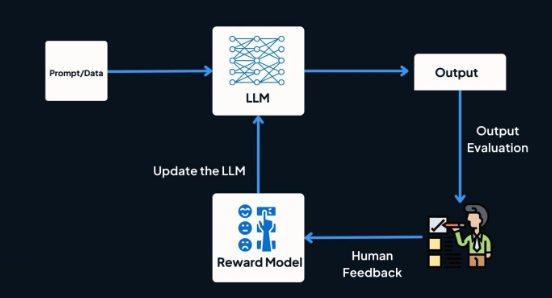



(Illustration from [2].)


In [2]:
KEY=""       #  must supply OpenAI Key

In [3]:

import os
os.environ["OPENAI_API_KEY"] = KEY

# from openai import OpenAI
# client = OpenAI()
# print(client.models.list())



### **How to Write an Effective ChatGPT Prompt**

* **Give a role or context:** Start by defining who the model should “be” (e.g., *“You are a statistics tutor explaining regression to beginners.”*).
* **State the task clearly:** Specify what you want—summarize, write, code, explain, critique, or reformat.
* **Be explicit about the output format:** Ask for *bullets, numbered lists, tables, JSON, or code blocks* to control structure.
* **Set boundaries:** Indicate tone, length, or audience (e.g., *“Keep it under 120 words and use plain language.”*).
* **Provide examples of inputs and outputs:** Show one or two examples of what good responses should look like.
* **Add background or constraints:** Supply any context, data, or assumptions needed for accuracy.
* **Use step-by-step or numbered instructions** for complex or multi-part requests.
* **Include evaluation criteria** if you want explanation or justification (*“Explain why this choice improves interpretability.”*).
* **Iterate and refine:** Rerun and adjust based on what you get back.
* **Ask ChatGPT for help writing better prompts:** You can say, *“Rewrite this prompt to make it clearer”* or *“Suggest a version that will yield more concise results.”*
* **Use temperature/top_p to control variation:** Lower = focused and precise; higher = more creative and exploratory.
* **Avoid ambiguity:** Replace vague requests like *“Tell me about…”* with *“List three key differences between…”*.





### Chain-of-Thought (CoT) — brief

* **What:** Ask the model to show **intermediate steps** before the final answer.
* **Why:** Improves reliability on multi-step tasks (math word problems, multi-hop QA, code debugging).
* **How (prompt):** “Think step by step. List 3–5 short steps, then give a one-line final answer.”
* **Pros:** Often boosts accuracy; reveals reasoning you can check.
* **Cons:** Longer outputs; can be confidently wrong if not constrained.
* **Tip:** Use **self-consistency** (sample multiple CoTs and vote) for tougher problems.

### Tree of Thoughts (ToT) — brief

* **What:** Generalizes CoT to a **search over multiple partial solutions** (“thoughts”) with scoring and backtracking.
* **Why:** Helps on tasks needing **planning/look-ahead** (puzzles, program synthesis, complex planning).
* **How (prompt):** “At each step, propose up to *k* candidate thoughts; score each (0–1) for promise; expand the top *b* for up to *d* steps; then return the best solution and a short justification.”
* **Pros:** Explores alternatives; more robust on hard reasoning/planning.
* **Cons:** More tokens/time; needs simple **heuristics** to score branches.
* **Tip:** Keep it small (e.g., *k*=3, *b*=2, *d*=3) and log branches for teaching/debugging.

If you want, I can turn these into a one-slide “CoT vs ToT” comparison with a tiny example prompt for each.


## GPT-5 API Demo 1: Chat Continuations

**How it works:**
Keep a running `messages` list of `{role, content}` turns (`system`, `user`, `assistant`). Each API call resends this history with the latest user message appended. Put durable tone and persona guidance in the **first `system` message** and reuse it every time.

OpenAI’s new *conversation-state* feature can manage history automatically (see official docs).

**Key parameters (Responses API):**

* `model`: Required each call (e.g. `"gpt-5"`).
* `instructions`: Optional first-call guidance (tone, format).
* `input`: Required user message.
* `previous_response_id`: The last response’s `.id` for follow-ups.
* Optional: `temperature`, `max_output_tokens`, `metadata`.

**Usage:**

* **First call:** `model`, `instructions`, `input`.
* **Follow-ups:** `model`, `input`, `previous_response_id`.
* Adjust style or length with `temperature` or `max_output_tokens`.



In [46]:
from openai import OpenAI
client = OpenAI()

# First turn
r1 = client.responses.create(
    model="gpt-5",
    # instructions="You are a concise Python tutor.",
    # instructions="You are William Shakespeare.",
    instructions="You are writing a press release for the newpaper.",
    input="Write a short bedtime story about a boy wanting to learn about linear regression."
)
print(r1.output_text)
print()

# Follow-up turn that CONTINUES the same chat
r2 = client.responses.create(
    model="gpt-5",
    previous_response_id=r1.id,          # <- key for continuation
    input="Include something about a visit by aliens in a spaceship but keep it short."
)
print(r2.output_text)
print()

# Follow-up turn that CONTINUES the same chat
r3 = client.responses.create(
    model="gpt-5",
    previous_response_id=r1.id,          # <- key for continuation
    input="The boy's name should be Wayne."
)
print(r3.output_text)

For immediate release

City Desk announces a new short bedtime story that gently introduces children to the idea behind linear regression through warmth, wonder, and plain language. The story, “The Line That Listened,” follows a curious boy who wants to understand how a single straight line can make sense of scattered dots. Aimed at families and young readers, it turns a big idea into a cozy, end-of-day read.

The Line That Listened (short bedtime story)

Leo lay beneath a quilt sprinkled with tiny stars, staring at a page of dots he’d drawn that afternoon. Some dots were high, some low, some drifting in the middle like sleepy boats on a pond.

“I want to learn how to draw the fairest line,” he whispered, “one that helps me guess what might come next.”

Grandma padded in, smelling faintly of cinnamon. She looked at the page and smiled. “Imagine each dot is a firefly with a small voice,” she said. “Some shout from up high, some whisper down low. We don’t chase just one. We listen to all

### GPT-5 Demo 2 — Structured Output (valid JSON extraction)

**Goal:** Pull structured facts from messy text and guarantee valid JSON.

In [39]:
from openai import OpenAI
import json
client = OpenAI()

note = """Meeting: Wed Oct 22, 3:30pm. Attendees: Dr. Lee (CMO), Priya Shah (PM), Wayne Snyder.
Decisions: Launch beta Nov 5. Budget +$25k. Owner: Priya. Follow-up: eval report by Oct 29."""

resp = client.responses.create(
    model="gpt-5",
    input=[
        {
            "role": "system",
            "content": (
                "Return ONLY valid JSON with keys: date_iso, time, attendees (array of {name, role}), "
                "decisions (array), owner, follow_up ({date_iso, task}). No commentary."
            ),
        },
        {"role": "user", "content": note},
    ],
)

out = resp.output_text
data = json.loads(out)  # will raise if not valid JSON
print(data)



{'date_iso': '2025-10-22', 'time': '15:30', 'attendees': [{'name': 'Dr. Lee', 'role': 'CMO'}, {'name': 'Priya Shah', 'role': 'PM'}, {'name': 'Wayne Snyder', 'role': ''}], 'decisions': ['Launch beta Nov 5.', 'Budget +$25k.'], 'owner': 'Priya Shah', 'follow_up': {'date_iso': '2025-10-29', 'task': 'eval report'}}


### GPT-5 Demo 3 — Multimodal Reasoning (image + text)

**Goal:** Feed an image and a question together; get grounded visual + textual reasoning.

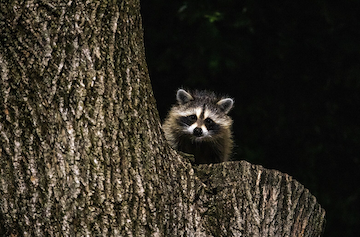

In [40]:
from openai import OpenAI
client = OpenAI()

img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/2023_06_08_Raccoon1.jpg/1599px-2023_06_08_Raccoon1.jpg"
prompt  = "Describe the scene briefly and infer the likely setting and time of day."

resp = client.responses.create(
    model="gpt-5",
    input=[{
        "role": "user",
        "content": [
            {"type": "input_text",  "text": prompt},
            {"type": "input_image", "image_url": img_url}
        ],
    }],
)
print(resp.output_text)


A raccoon peeks from behind a large, rough-barked tree, lit against a dark background. The setting is likely a wooded area or park. The deep shadows and the animal’s nocturnal behavior suggest evening or nighttime.


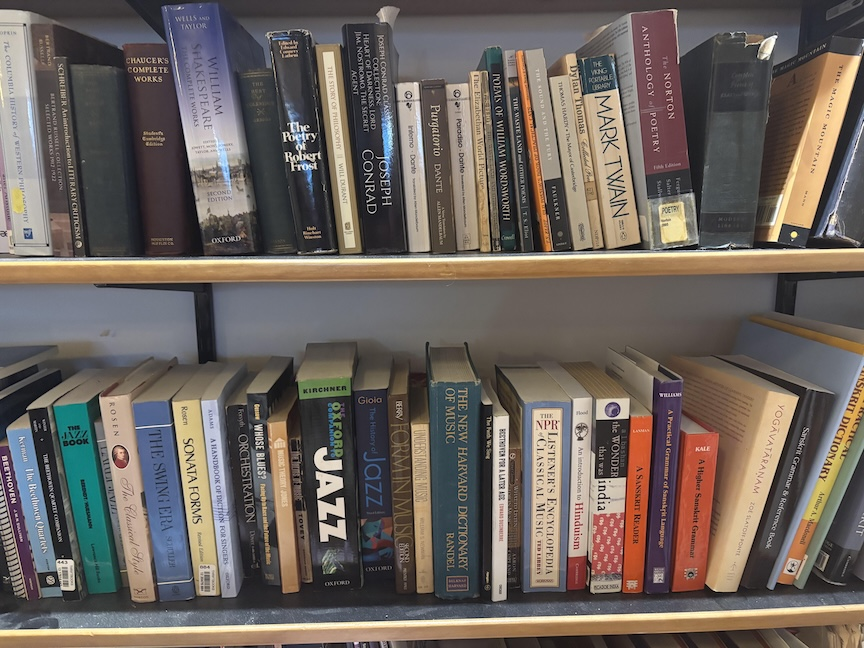

In [41]:
import base64, mimetypes, pathlib
from openai import OpenAI

client = OpenAI()

# --- your local image ---
path = pathlib.Path("BookShelf.jpg")   # change to your filename
mime, _ = mimetypes.guess_type(path.name)
mime = mime or "image/jpeg"            # safe default

# --- make a data URL ---
b64 = base64.b64encode(path.read_bytes()).decode("utf-8")
data_url = f"data:{mime};base64,{b64}"

prompt = "Which books seem the thickest?"

resp = client.responses.create(
    model="gpt-5",
    input=[{
        "role": "user",
        "content": [
            {"type": "input_text",  "text": prompt},
            {"type": "input_image", "image_url": data_url}
        ],
    }],
)

print(resp.output_text)


The thickest-looking ones are:
- Chaucer’s Complete Works (top left, purple spine)
- William Shakespeare – Wells & Taylor (top left, dark blue)
- The Norton Anthology of Poetry (top right, dark green)
- Mark Twain (top right, white spine)
- The New Harvard Dictionary of Music (bottom center-right, blue/teal)
- The Listener’s Encyclopedia of Classical Music (bottom right, beige)
- A Sanskrit Grammar – Kale (bottom far right, tan)


> 📌 **What students will see:**
>
> 1. Same prompt, different temperatures → different phrasing/variety.
> 2. Same task, different **prompt styles** (role, structure, concision) → different shape/clarity of answers.
> 3. A tiny “A/B” experiment harness you can reuse in other lessons.

---

### 0) Setup

In [42]:
# If running in Colab: !pip -q install --upgrade openai

import os
from openai import OpenAI

# Make sure your key is in the environment (preferred):
#   export OPENAI_API_KEY="sk-..."
# or set it programmatically (not recommended to hardcode in shared notebooks):
# os.environ["OPENAI_API_KEY"] = "sk-..."

client = OpenAI()
print([m.id for m in client.models.list().data])


['gpt-4-0613', 'gpt-4', 'gpt-3.5-turbo', 'gpt-5-search-api-2025-10-14', 'gpt-realtime-mini', 'gpt-realtime-mini-2025-10-06', 'sora-2', 'sora-2-pro', 'davinci-002', 'babbage-002', 'gpt-3.5-turbo-instruct', 'gpt-3.5-turbo-instruct-0914', 'dall-e-3', 'dall-e-2', 'gpt-4-1106-preview', 'gpt-3.5-turbo-1106', 'tts-1-hd', 'tts-1-1106', 'tts-1-hd-1106', 'text-embedding-3-small', 'text-embedding-3-large', 'gpt-4-0125-preview', 'gpt-4-turbo-preview', 'gpt-3.5-turbo-0125', 'gpt-4-turbo', 'gpt-4-turbo-2024-04-09', 'gpt-4o', 'gpt-4o-2024-05-13', 'gpt-4o-mini-2024-07-18', 'gpt-4o-mini', 'gpt-4o-2024-08-06', 'chatgpt-4o-latest', 'o1-mini-2024-09-12', 'o1-mini', 'gpt-4o-realtime-preview-2024-10-01', 'gpt-4o-audio-preview-2024-10-01', 'gpt-4o-audio-preview', 'gpt-4o-realtime-preview', 'omni-moderation-latest', 'omni-moderation-2024-09-26', 'gpt-4o-realtime-preview-2024-12-17', 'gpt-4o-audio-preview-2024-12-17', 'gpt-4o-mini-realtime-preview-2024-12-17', 'gpt-4o-mini-audio-preview-2024-12-17', 'o1-2024-1

### 1) A small “experiment harness”

In [43]:
def call_gpt(system_prompt, user_prompt, temperature=0.3, max_tokens=400):
    from openai import OpenAI
    client = OpenAI()
    resp = client.responses.create(
        model='gpt-4o',
        temperature=temperature,
        max_output_tokens=max_tokens,       # <-- new name
        input=[
            {"role": "system", "content": system_prompt},
            {"role": "user",   "content": user_prompt},
        ],
    )
    return resp.output_text.strip()


def show_run(title, system_prompt, user_prompt, temperature):
    print(f"\n=== {title} | temp={temperature} ===\n")
    print(call_gpt(system_prompt, user_prompt, temperature))

### 2) Common task (keeps the content constant)

We’ll ask the model to **summarize a tabular dataset** for a non-technical stakeholder.

In [44]:
TASK = """
You are given a small tabular dataset with customer records for a subscription business.
Columns: customer_id, signup_date, plan_tier, monthly_fee, is_churned, region, sessions_last_30d.

Task: Summarize 3 actionable insights that could inform retention strategy.
Avoid math steps—focus on clear business language.
"""

### 3) Temperature sweep (same prompt, different temperatures)

In [45]:
MODEL

'gpt-5'

In [27]:
system_base = "You are a concise data analyst who writes clear, business-ready insights."
user_base   = TASK + "\nKeep it to 120 words or less."

for t in [0.0, 0.5, 0.9]:
    show_run("Temperature Sweep", system_base, user_base, temperature=t)


=== Temperature Sweep | temp=0.0 ===
1. **Target High-Value Customers**: Focus retention efforts on customers with higher plan tiers and monthly fees, as they contribute more revenue. Personalized offers or loyalty programs could enhance their experience and reduce churn.

2. **Engage At-Risk Regions**: Identify regions with higher churn rates and implement targeted engagement strategies. Tailored communication and region-specific promotions can address unique needs and improve retention.

3. **Boost Low-Engagement Users**: Customers with fewer sessions in the last 30 days are more likely to churn. Develop initiatives to increase platform engagement, such as personalized content recommendations or interactive features, to keep these users active and invested.

=== Temperature Sweep | temp=0.5 ===
1. **Targeted Retention Offers:** Identify customers in higher plan tiers who have churned. Offering tailored incentives or discounts could encourage them to return, as they represent higher 

> **Teaching note:**
>
> * **0.0** → more deterministic phrasing, fewer creative turns of phrase.
> * **0.5** → balanced variety.
> * **0.9** → more diverse/creative suggestions, sometimes bolder assumptions.

---

### 4) Prompt-style variants (role, structure, concision)

#### 4a) Role-based prompt

In [28]:
system_role = "You are a senior product manager specializing in growth and retention."
user_role   = TASK + "\nWrite for an executive audience. End with 1 next step."

show_run("Role-based Style", system_role, user_role, temperature=0.4)


=== Role-based Style | temp=0.4 ===
**Actionable Insights:**

1. **Plan Tier Impact on Churn:**
   Customers on lower-tier plans may exhibit higher churn rates. This suggests that these plans might not offer sufficient value or features. Enhancing the benefits of lower-tier plans or providing targeted upsell opportunities could improve retention.

2. **Regional Variations:**
   Certain regions might have higher churn rates compared to others. This could be due to cultural preferences or regional competition. Tailoring marketing and engagement strategies to address specific regional needs could reduce churn.

3. **Engagement Correlation:**
   There is likely a strong correlation between customer engagement, as measured by sessions in the last 30 days, and retention. Increasing engagement through personalized content, reminders, or community-building activities could enhance customer loyalty.

**Next Step:**
Conduct a detailed analysis of customer feedback and behavior to identify speci

#### 4b) Structured output (bullet requirements)

In [29]:
system_struct = "You are a data analyst who writes crisp, skimmable briefs."
user_struct   = TASK + """
Output format:
- Insight 1: <one sentence>
- Evidence: <one sentence>
- Action: <one sentence>
(repeat for 3 insights)
Total <= 130 words.
"""

show_run("Structured Style", system_struct, user_struct, temperature=0.4)


=== Structured Style | temp=0.4 ===
- Insight 1: High-tier plan customers show lower churn rates.
  - Evidence: Customers on premium plans are less likely to churn compared to those on lower tiers.
  - Action: Offer incentives to upgrade plans, such as discounts or added features.

- Insight 2: Customers with more sessions are less likely to churn.
  - Evidence: Data indicates a strong correlation between frequent platform use and retention.
  - Action: Implement engagement initiatives, like personalized content or notifications, to increase session frequency.

- Insight 3: Churn rates vary significantly by region.
  - Evidence: Certain regions exhibit higher churn rates, suggesting regional dissatisfaction or competition.
  - Action: Conduct regional surveys to identify specific issues and tailor retention strategies accordingly.


#### 4c) Concise vs. expansive (same task, different constraints)

In [30]:
system_concise = "You are a data analyst. Prioritize brevity and clarity."
user_concise   = TASK + "\nDeliver exactly 3 bullet points, each 1 sentence."

show_run("Concision Constraint", system_concise, user_concise, temperature=0.3)

system_expansive = "You are a data analyst. Provide a brief narrative with transitions."
user_expansive   = TASK + "\nWrite a single paragraph (150–180 words)."

show_run("Expansive Narrative", system_expansive, user_expansive, temperature=0.5)


=== Concision Constraint | temp=0.3 ===
- Customers on higher plan tiers who have churned may indicate a need for enhanced value or engagement strategies to justify the cost.
- Regions with higher churn rates could benefit from targeted retention campaigns or localized offers to improve customer loyalty.
- Customers with fewer sessions in the last 30 days before churning suggest a need for proactive engagement tactics to increase platform usage.

=== Expansive Narrative | temp=0.5 ===
Analyzing the dataset reveals several insights to enhance customer retention. First, customers on higher-tier plans, despite paying more, show a lower churn rate. This suggests that premium features or benefits may be effectively retaining these users, indicating a potential strategy to upsell lower-tier customers by highlighting the value of upgrading. Secondly, regional differences in churn rates are evident, with certain areas exhibiting higher customer loss. This points to the need for region-specifi

### 5) Adding lightweight **tuning knobs** (length + “style” without changing temperature)

In [31]:
def styled_summary(style_hint, temperature=0.4):
    system = "You are a helpful data analyst."
    user = TASK + f"\nStyle hint: {style_hint}\nCap at 120 words."
    return call_gpt(system, user, temperature=temperature)

print("\n=== Style: neutral ===")
print(styled_summary("neutral, plain business tone"))

print("\n=== Style: optimistic / motivational ===")
print(styled_summary("optimistic, motivational, but still professional"))

print("\n=== Style: risk-focused / cautious ===")
print(styled_summary("risk-focused, cautious, highlight potential downsides"))


=== Style: neutral ===
1. **Plan Tier Optimization**: Analyze the correlation between plan tiers and churn rates. If higher-tier plans show lower churn, consider promoting upgrades with incentives. Conversely, if lower-tier plans have higher retention, ensure they meet customer needs effectively.

2. **Regional Focus**: Identify regions with higher churn rates. Tailor retention strategies, such as localized offers or targeted communication, to address specific regional challenges or preferences.

3. **Engagement Enhancement**: Examine the relationship between session frequency and churn. Customers with fewer sessions may require engagement boosts, such as personalized content or reminders, to increase their activity and connection with the service.

=== Style: optimistic / motivational ===
Absolutely! Here are three actionable insights to boost customer retention:

1. **Personalized Engagement:** Focus on customers in regions with higher churn rates. Tailor communication and offers to

#### Parameters you MIGHT be able to set in the OpenAI API:

**Generation & length**

* `top_p`: nucleus sampling (0–1).
* `max_output_tokens`: hard cap on generated tokens.
* `stop`: string or list of strings to halt generation. ([OpenAI Platform][1])

**Determinism & truncation**

* `seed`: make outputs reproducible (when supported).
* `truncation`: control how long inputs are trimmed if they exceed context. ([OpenAI Platform][2])

**Reasoning controls (when supported)**

* `reasoning`: e.g., `{"effort":"low" | "medium" | "high"}` to budget reasoning tokens. ([OpenAI Platform][3])

**Tool use**

* `tools`: declare functions / tools the model may call.
* `tool_choice`: `"auto" | "none" | {"type":"function","function":{"name":"..."}}"`
* `parallel_tool_calls`: allow multiple tool calls in one turn.
* `max_tool_calls`: cap total tool calls. ([OpenAI Platform][4])

**Structured outputs / JSON**

* `response_format`: enforce structure (e.g., JSON Schema) for guaranteed parseable output. ([OpenAI Platform][5])

**Streaming**

* `stream`: `True/False` to stream tokens.
* `stream_options`: e.g., `{"include_usage": true}` to get usage during streams. ([Stack Overflow][6])

**Return-shaping & state**

* `include`: choose extra fields to return (usage, tool calls, reasoning, etc.).
* `previous_response_id`: chain statefully to a prior Responses call. ([OpenAI Platform][1])

**Meta & routing**

* `user`: end-user identifier for abuse/fraud analysis.
* `metadata`: arbitrary key/values you attach to the run.
* `service_tier`, `store`, `prompt_cache_key`: advanced routing/caching flags. ([OpenAI Platform][7])

Here’s a compact pattern showing several together:

```python
resp = client.responses.create(
    model="gpt-4o",
    temperature=temperature,
    top_p=0.9,
    max_output_tokens=max_tokens,
    stop=["</end>"],
    seed=42,
    reasoning={"effort": "medium"},  # if supported by the model
    tools=[{
        "type": "function",
        "function": {
            "name": "lookup_fact",
            "description": "Get a short fact by key",
            "parameters": {"type":"object","properties":{"key":{"type":"string"}}, "required":["key"]}
        }
    }],
    tool_choice="auto",
    parallel_tool_calls=True,
    max_tool_calls=3,
    response_format={  # enforce JSON result shape
        "type": "json_schema",
        "json_schema": {
            "name": "brief_answer",
            "schema": {
                "type": "object",
                "properties": {"answer": {"type":"string"}, "sources": {"type":"array","items":{"type":"string"}}},
                "required": ["answer"]
            }
        }
    },
    stream=False,
    input=[
        {"role":"system","content": system_prompt},
        {"role":"user","content":   user_prompt},
    ],
    user="student-ml-101",
    metadata={"lesson":"prompt-sweeps"}
)
```

Notes:

* Availability is **model-dependent**: if a parameter errors (e.g., `temperature` on some `gpt-5` routes), drop it for that model. ([OpenAI Platform][8])
* Full parameter list and nuances are in the **Responses API** reference and related guides. ([OpenAI Platform][1])



[1]: https://platform.openai.com/docs/api-reference/responses?utm_source=chatgpt.com "Responses API reference"
[2]: https://platform.openai.com/docs/advanced-usage?utm_source=chatgpt.com "Advanced usage - OpenAI API"
[3]: https://platform.openai.com/docs/guides/reasoning?utm_source=chatgpt.com "Reasoning models - OpenAI API"
[4]: https://platform.openai.com/docs/guides/tools?utm_source=chatgpt.com "Using tools - OpenAI API"
[5]: https://platform.openai.com/docs/guides/structured-outputs?utm_source=chatgpt.com "Structured model outputs - OpenAI API"
[6]: https://stackoverflow.com/questions/75824798/how-to-get-token-usage-for-each-openai-chatcompletion-api-call-in-streaming-mode?utm_source=chatgpt.com "How to get token usage for each openAI ChatCompletion ..."
[7]: https://platform.openai.com/docs/api-reference/introduction?utm_source=chatgpt.com "API Reference - OpenAI Platform"
[8]: https://platform.openai.com/docs/guides/latest-model?utm_source=chatgpt.com "Using GPT-5 - OpenAI API"


## References

These papers have been used to prepare this notebook, along with, of course, `ChatGPT`. 

1. **Transformer models: an Introduction and Catalog -- 2023 Edition.**     This paper does an excellent job of describing the development of the transformer model family up through 2023,     and includes a long catalog, with links, to all the models discussed. 

> https://amatria.in/blog/transformer-models-an-introduction-and-catalog-2d1e9039f376/

2. **What is Reinforcement Learning from Human Feedback (RLHF) and How Does it Work?**   A well-written survey of RLHF.

> https://www.twine.net/blog/what-is-reinforcement-learning-from-human-feedback-rlhf-and-how-does-it-work/